# **Teoria da Decisão - TC3**

### Marcos Rezende 2019027067
### Tiago Porto 2019027202

Instalação dos módulos utilizados

In [85]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
class Struct:
  pass


Carrega os dados do problema para a variável probdata

In [86]:
def probdef():
  originaldata = pd.read_csv('clientes.csv', header=None)
  dataframe = pd.DataFrame(originaldata)
  probdata = Struct()
  probdata.coord = []
  for i in range(len(dataframe[0])):
    probdata.coord.append([dataframe[0][i], dataframe[1][i]])

  probdata.x = dataframe[0]
  probdata.y = dataframe[1]
  probdata.intensity = dataframe[2]
  return probdata

Definição da função Shake.
As estruturas de vizinhança implementadas foram:


*   Movimenta um número aleatório de PAs de 5 a 15 metros em qualquer direção
*   Movimenta todos os PAs de 5 a 15 metros em qualquer direção
*   Adiciona um novo PA


In [87]:
def shake(x,k):
    y = copy.deepcopy(x)
    r = np.random.randint(0, len(x.solution)) # número de PAs que serão movidos
    if k == 1:             # Movimenta um número aleatório de PAs 5 metros em uma direção aleatória

      for i in range(r):
        movX = np.random.randint(-1,1)*5
        movY = np.random.randint(-1,1)*5


        if(y.solution[i][0] + movX < 400 and y.solution[i][0] + movX > 0):
            y.solution[i][0] = y.solution[i][0] + movX
        else:
          y.solution[i][0] = y.solution[i][0] - movX

        if(y.solution[i][1] + movY < 400 and y.solution[i][1] + movY > 0):
            y.solution[i][1] = y.solution[i][1] + movY
        else:
          y.solution[i][1] = y.solution[i][1] - movY

    elif k == 2:    # Movimenta TODOS os PAs 5 metros em uma direção aleatória
      for i in range(len(x.solution)):
        movX = np.random.randint(-1,1)*5*np.random.randint(1,3)
        movY = np.random.randint(-1,1)*5*np.random.randint(1,3)
        # print(movX, movY)

        if(y.solution[i][0] + movX < 400 and y.solution[i][0] + movX > 0):
            y.solution[i][0] = y.solution[i][0] + movX
        else:
          y.solution[i][0] = y.solution[i][0] - movX

        if(y.solution[i][1] + movY < 400 and y.solution[i][1] + movY > 0):
            y.solution[i][1] = y.solution[i][1] + movY
        else:
          y.solution[i][1] = y.solution[i][1] - movY

    elif k == 3:
        # Adiciona um novo PA em uma posição aleatória
        # if(len(x.solution) < 25):
        tempPA = [np.random.randint(0,81)*5, np.random.randint(0,81)*5]
        y.solution.append(tempPA)
    elif k == 4:
      if(len(y.solution) > 1):
        pos = np.random.randint(0, len(y.solution) - 1)
        del y.solution[pos]
    return y

Definição da Heuristica Construtiva.
A Lógica utilizada foi distribuir igualmente os PAs ao longo de toda a extensão do local

In [88]:
def generate_initial_solution(f):
  # Distribuir igualmente 9 PAs por todo o ambiente

  y = []
  if f == "f1":
    for i in range(3):
      for j in range(3):
        coordY = ((j)*133) + 70
        coordX = ((i)*133) + 70
        y.append([coordX,coordY])
  elif f == "f3":
    for i in range(5):
      for j in range(5):
        coordY = ((j)*80) + 60
        coordX = ((i)*80) + 60
        y.append([coordX,coordY])

  else:
    for i in range(5):
      for j in range(5):
        coordY = ((j)*80)
        coordX = ((i)*80)
        y.append([coordX,coordY])
  x = Struct()
  x.solution = y
  return x

# generate_initial_solution()

Troca de vizinhança


In [89]:
def neighborhoodChange(x, y, k):

    if y.fitness < x.fitness:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1

    return x, k

Função para calcular a distância euclidiana entre 2 pontos

In [90]:
def calcDist(coord1, coord2):
  return abs(math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2))


Definição da função objetivo e restrições


In [91]:
colors = [
    "#00FFFF", "#0000FF", "#008000", "#FFFF00", "#FFA500",
    "#800080", "#00FF00", "#FF00FF", "#008080", "#FFD700",
    "#A52A2A", "#696969", "#2E8B57", "#800000", "#9400D3",
    "#00CED1", "#8A2BE2", "#6B8E23", "#20B2AA", "#32CD32",
    "#808000", "#008B8B", "#483D8B", "#2F4F4F", "#008080", "#00FFFF", "#0000FF", "#008000", "#FFFF00", "#FFA500",
    "#800080", "#00FF00", "#FF00FF", "#008080", "#FFD700",
    "#A52A2A", "#696969", "#2E8B57", "#800000", "#9400D3",
    "#00CED1", "#8A2BE2", "#6B8E23", "#20B2AA", "#32CD32",
    "#808000", "#008B8B", "#483D8B", "#2F4F4F", "#008080"
  ]

In [92]:
def normalizaFuncoes(fx, f):
    if(f == "f1"):
        return (fx - 0)/(25 - 0)
    else:
        return (fx - 6891)/(56510-6891)

In [93]:
def fobj(x, probdata, f, e):


  penalidade = 0.0



  #  R5: Penaliza a solução se tiver mais de 25 PAs
  if(len(x.solution) > 25):
    # pass
    penalidade += (len(x.solution) - 25)**2 * 100


  # R3 e R4: Penaliza a solução se nem todos os clientes estiverem no raio de atuação de um PA
  # e que cada cliente esteja conectado em apenas 1 PAa

  clientes = []
  for i in range(len(probdata.coord)):

    cliente = Struct()
    cliente.id = i
    cliente.pa = None
    cliente.dist_pa = 0.0
    cliente.color = '#ff0000'
    cliente.coord = probdata.coord[i]
    clientes.append(cliente)

    for j in range(len(x.solution)):
      dist = calcDist(x.solution[j], probdata.coord[i])
      if(dist <= 70):

        if not(clientes[i].pa == None):
          if(clientes[i].dist_pa > dist):
            clientes[i].dist_pa = dist
            clientes[i].pa = j
            clientes[i].color = colors[j]
        else:
          clientes[i].dist_pa = dist
          clientes[i].pa = j
          clientes[i].color = colors[j]
      else:
        if(clientes[i].dist_pa == None):
          clientes[i].dist_pa = dist
        else:
          if(clientes[i].dist_pa > dist):
            clientes[i].dist_pa = dist



  clientes_nao_atendidos = np.sum([cliente.pa is None for cliente in np.array(clientes)])
  # R1: Todos os clientes tem que ser atendidos (considerando cobertura 95%)
  toleranacia =  len(probdata.coord)*0.05 - clientes_nao_atendidos
  if(toleranacia < 0):
    # pass
    # print(clientes_nao_atendidos)
    penalidade += 100 * toleranacia**2


  # R2: Penaliza se a quantidade de clientes conectados ultrapassar a capacidade do PA
  pas = np.zeros(len(x.solution))
  variancia = 0
  capacidade = 54
  for i in clientes:
    pas[i.pa] += probdata.intensity[i.id]
    filteredArray = np.where(pas <= capacidade, 0, pas)
    penalidade +=  abs(np.sum(filteredArray**2)*100)
    variancia += (probdata.intensity[i.id] - (np.sum(pas)/len(pas)))**2
  variancia = (variancia/len(pas))**(1/2)
  # fitness = len(x.solution)
  
  # fitnessF2 = 0.0
  # for i in clientes:
  #   fitnessF2 += i.dist_pa
  
  # if fitnessF2 > e:
  #  penalidade = (fitnessF2 - e)**2 * 100

  fitness = 0
  
  for i in clientes:
    fitness += i.dist_pa
  
  if len(x.solution) >= e:
   penalidade += (len(x.solution) - e)**2 * 100

  x.capacidade = pas
  x.variancia = variancia
  x.consumo_medio_rede = (np.sum(pas)/len(pas))
  x.fitness = fitness + penalidade
  x.clientes = clientes
  x.f1 = len(x.solution)
  x.f2 = fitness
  return x








Implementação do Best Improvement

In [94]:
def bestImprovement(x, kmax, probdata, f, w):

  y = copy.deepcopy(x)
  melhorSolucao = fobj(y, probdata, f,w)
  for k in range(kmax):
    y = shake(y,k+1)
    resultado = fobj(y, probdata, f, w)
    if(resultado.fitness <= melhorSolucao.fitness):
      melhorSolucao = resultado
  return melhorSolucao


Função para evitar acrescentar soluções dominadas no conjunto de soluções

In [95]:
def nondominatedsolution(solutionsList, currentSolution):
    if(len(solutionsList) == 0):
        return True
    for solution in solutionsList:
        if(currentSolution[0] >= solution.f1 and currentSolution[1] > solution.f2):
            return False
    return True

Função para limpar possíveis soluções dominadas do conjunto de soluções

In [96]:
def removeDominatedSolutions (solutionsList):
    for solution in solutionsList:
        for solution2 in solutionsList:
            if(solution2.f1 >= solution.f1 and solution2.f2 > solution.f2):
                solutionsList.remove(solution2)
    return solutionsList



### Implementação do método BVNS

In [97]:
fronteira_final = []

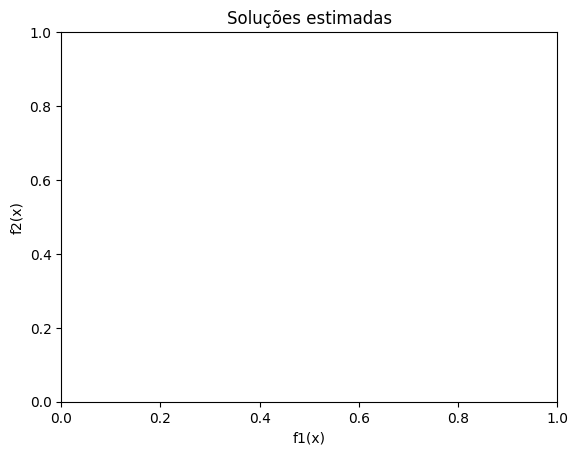

In [98]:
'''
Implementa uma metaheurística BVNS
'''

def bvns(f, max_num_sol_avaliadas):

  global fronteira_final
  # Número de estruturas de vizinhanças definidas
  kmax = 4

  # Faz a leitura dos dados da instância do problema
  probdata = probdef()

  # Gera solução inicial
  initial_solution = generate_initial_solution(f)

 
  # Contador do número de soluções candidatas avaliadas
  min_episolon = 9
  max_episolon = 25


  # Ciclo iterativo do método
  for color in ["b.", "g.", "r.", "y.", "k."]:
    solucoes = []
    num_iteracoes = 0
    max_iteracoes = 50
    while len(solucoes) < 20 and num_iteracoes < max_iteracoes:
      if(num_iteracoes > max_iteracoes):
        break
      num_iteracoes += 1
      print ("Num Solucoes: {} Num Iteracoes {}".format(len(solucoes), num_iteracoes))

      num_sol_avaliadas = 1
      episolon = random.randint(min_episolon, max_episolon)
      x = fobj(initial_solution,probdata, f, episolon)
      fit = None
      globalX = None

      while num_sol_avaliadas < max_num_sol_avaliadas:

        k = 1
        while k <= kmax:

          # Gera uma solução candidata na k-ésima vizinhança de x
          y = shake(x,k)
          y = fobj(y,probdata, f, episolon)

          y = bestImprovement(y, kmax, probdata, f, episolon)
          num_sol_avaliadas += 1

          # Atualiza solução corrente e estrutura de vizinhança (se necessário)
          x,k = neighborhoodChange(x,y,k)
          if fit == None or fit >= x.fitness:
            fit = x.fitness
            globalX = x
          if num_sol_avaliadas > max_num_sol_avaliadas:
            break

      isNonDominatedSolution = nondominatedsolution(solucoes, [globalX.f1, globalX.f2])
      if(isNonDominatedSolution == True):
        solucoes.append(globalX)
        solucoes = removeDominatedSolutions(solucoes)

    for i in solucoes:
      print("f1 {} f2 {}".format(i.f1, i.f2))
      plt.plot(i.f1,i.f2,color)
      
    fronteira_final = fronteira_final + solucoes #popula o array final

plt.title('Soluções estimadas')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.show()



Num Solucoes: 0 Num Iteracoes 1


Num Solucoes: 1 Num Iteracoes 2
Num Solucoes: 1 Num Iteracoes 3
Num Solucoes: 2 Num Iteracoes 4
Num Solucoes: 2 Num Iteracoes 5
Num Solucoes: 3 Num Iteracoes 6
Num Solucoes: 4 Num Iteracoes 7
Num Solucoes: 4 Num Iteracoes 8
Num Solucoes: 5 Num Iteracoes 9
Num Solucoes: 5 Num Iteracoes 10
Num Solucoes: 5 Num Iteracoes 11
Num Solucoes: 5 Num Iteracoes 12
Num Solucoes: 5 Num Iteracoes 13
Num Solucoes: 5 Num Iteracoes 14
Num Solucoes: 5 Num Iteracoes 15
Num Solucoes: 5 Num Iteracoes 16
Num Solucoes: 5 Num Iteracoes 17
Num Solucoes: 5 Num Iteracoes 18
Num Solucoes: 5 Num Iteracoes 19
Num Solucoes: 5 Num Iteracoes 20
Num Solucoes: 5 Num Iteracoes 21
Num Solucoes: 5 Num Iteracoes 22
Num Solucoes: 5 Num Iteracoes 23
Num Solucoes: 6 Num Iteracoes 24
Num Solucoes: 6 Num Iteracoes 25
Num Solucoes: 7 Num Iteracoes 26
Num Solucoes: 7 Num Iteracoes 27
Num Solucoes: 8 Num Iteracoes 28
Num Solucoes: 8 Num Iteracoes 29
Num Solucoes: 8 Num Iteracoes 30
Num Solucoes: 8 Num Iteracoes 31
Num Solucoes: 8 Nu

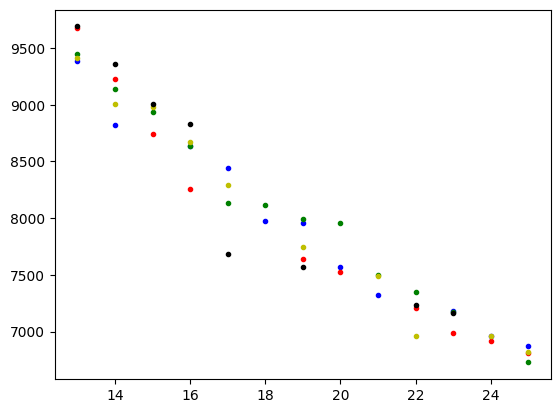

In [99]:
bvns("f1", 300) 

Fronteira Pareto Ótima

21; 7320.584131668452; 31.991013248707045; 19.959341108209884
13; 9388.748587554897; 54.800875934512554; 23.669973961896297
14; 8817.520952850076; 49.33603140213979; 24.253736671498338
25; 6728.393440060214; 20.747830585484913; 16.996609853355686
15; 8746.047150255841; 46.47855993430108; 24.069177116193814
16; 8260.210744651753; 45.19152536143767; 22.499629270076355
20; 7523.0169719729065; 33.48005796188546; 19.695740683862493
24; 6920.968969685068; 30.147006912551948; 19.565533636385865
22; 6962.873443784827; 30.55566154721886; 17.703739074171025
17; 7687.690182780126; 34.971078534814076; 21.42004927967611
19; 7568.140328400888; 28.98953513856026; 19.45179533488468


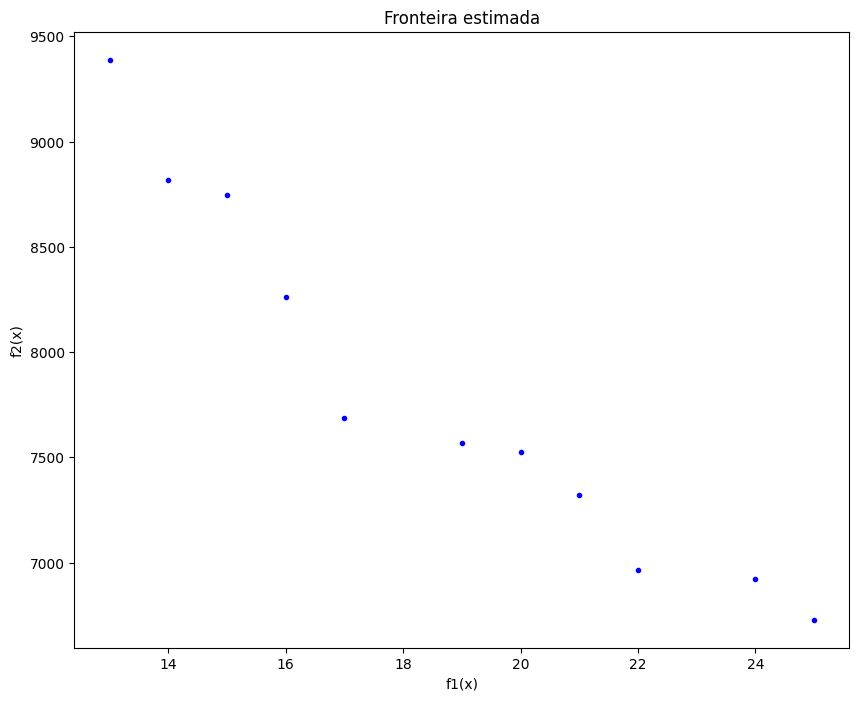

In [131]:
# Código para printar somente a fronteira com soluções não dominadas
fronteira_final = removeDominatedSolutions(fronteira_final)

plt.figure(figsize=(10,8))
for i in fronteira_final:
      print("{}; {}; {}; {}".format(i.f1, i.f2, i.variancia, i.consumo_medio_rede))
      plt.plot(i.f1,i.f2, "b.")

plt.title('Fronteira estimada')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.show()


# Métodos de auxílio à tomada de decisão

Critérios escolhidos:

    - Quantidade de PAs (menor melhor)
        - Peso: 0.3
    - Distância entre cliente e PA (menor melhor)
        - Peso: 0.2
    - Variância no uso de banda dos PAs (menor melhor)
        - Peso: 0.2
    - Médiia do uso de banda dos PAs (menor melhor)
        - Peso: 0.3


In [142]:
matriz_decisao = []
pesos = np.array([0.1,0.4,0.3,0.2])

for i in fronteira_final:
    matriz_decisao.append([i.f1, i.f2, i.variancia, i.consumo_medio_rede])


matriz_decisao = np.array(matriz_decisao)

Implementação do Método ELECTREE I

In [102]:
def calculateValue (value, min, max, minNormalizedValue, maxNormalizedValue):


    result = ((float(value) - float(min)) * (float(maxNormalizedValue)-float(minNormalizedValue)))/(float(max)-float(min))
    return result#float(f'{result:.2f}')


In [132]:
def normalizeMatrix(matrix, maxNormalizedValue, nonBeneficialCriteria):
    minNormalizedValue = 0.0
    normalizedMatrix = copy.deepcopy(matrix)

    for linha in range(matrix.shape[0]):
        min_value = 0
        max_value = 0
        for coluna in range(matrix.shape[1]):
            min_value = matrix.min(0)[coluna]
            max_value = matrix.max(0)[coluna]
            if(nonBeneficialCriteria.__contains__(coluna)):
                #nesse caso, menor é melhor, então max_value e min_value estão invertidos
                normalizedMatrix[linha][coluna] = calculateValue(matrix[linha][coluna], max_value, min_value, minNormalizedValue, maxNormalizedValue)
            else:
                normalizedMatrix[linha][coluna] = calculateValue(matrix[linha][coluna], min_value, max_value, minNormalizedValue, maxNormalizedValue)
    return normalizedMatrix

In [133]:
def matrixP(normalizedMatrix, weights):

    matrixPPlus = []
    matrixPEqual = []
    matrixPMinus = []
    concordance = []

    for linha in range(normalizedMatrix.shape[0]):
        arrayPPlus = []
        arrayPEqual = []
        arrayPMinus = []
        for linha2 in range(normalizedMatrix.shape[0]):
            sumPplus = 0
            sumPequal = 0
            sumPminus = 0
            for coluna in range(normalizedMatrix.shape[1]):
                if(linha != linha2):
                    if(normalizedMatrix[linha][coluna] > normalizedMatrix[linha2][coluna]):
                        sumPplus += weights[coluna]
                    elif(normalizedMatrix[linha][coluna] == normalizedMatrix[linha2][coluna]):
                        sumPequal += weights[coluna]
                    else:
                        sumPminus += weights[coluna]
            arrayPPlus.append(sumPplus)
            arrayPEqual.append(sumPequal)
            arrayPMinus.append(sumPminus)
        matrixPPlus.append(arrayPPlus)
        matrixPEqual.append(arrayPEqual)
        matrixPMinus.append(arrayPMinus)

    # print(matrixPPlus)
    # print(matrixPEqual)
    print(matrixPMinus)


In [105]:
def concordanceMatrix(normalizedMatrix, weights):

    concordance = []

    for linha in range(normalizedMatrix.shape[0]):
        arrayConcordance = []
        for linha2 in range(normalizedMatrix.shape[0]):
            sumConcordance = 0
            for coluna in range(normalizedMatrix.shape[1]):
                if(linha != linha2):
                    if(normalizedMatrix[linha][coluna] >= normalizedMatrix[linha2][coluna]):
                        sumConcordance += weights[coluna]
            arrayConcordance.append(sumConcordance)
        concordance.append(arrayConcordance)

    return np.array(concordance)


In [106]:
def discordanceMatrix(matrix):
    delta = 1/20

    disconcordance = []

    for linha in range(matrix.shape[0]):
        arrayDisoncordance = []
        for linha2 in range(matrix.shape[0]):
            maxDiscordance = 0
            for coluna in range(matrix.shape[1]):
                if(linha != linha2):

                    valorAtual = matrix[linha][coluna]
                    valorComparar = matrix[linha2][coluna]

                    if(valorAtual < valorComparar  and valorComparar - valorAtual > maxDiscordance):
                        maxDiscordance = valorComparar - valorAtual
            arrayDisoncordance.append(maxDiscordance*delta)
        disconcordance.append(arrayDisoncordance)

    return np.array(disconcordance)



In [107]:
def classificacao(concordance_matrix, discordance_matrix, thresholds):
    limiar_concordancia, limiar_discordancia = thresholds

    num_alternatives, num_pares = concordance_matrix.shape

    # Inicializa a lista de classificações
    classificacoes = []

    for i in range(num_alternatives):

        for j in range(num_pares):
            # Verifica os limiares de concordância e discordância para cada par

            # Conta as concordâncias e discordâncias
            if concordance_matrix[i][j] >= limiar_concordancia and discordance_matrix[i][j] <= limiar_discordancia:
                classificacoes.append([i+1,j+1])

    return np.array(classificacoes)

In [108]:

def electre_ordem_preferencia(matriz_classificacao, ordem):

    sobreclassificadores = []
    sobreclassificados = []

    for item in matriz_classificacao:
        if(not sobreclassificadores.__contains__(item[0])):
            sobreclassificadores.append(item[0])
        if(not sobreclassificados.__contains__(item[1])):
            sobreclassificados.append(item[1])

    result = np.setdiff1d(np.array(sobreclassificadores), np.array(sobreclassificados))
    ordem.append(result)
    return result,ordem


In [109]:

def recursivo (matriz_classificacao):
    ordem = []
    matriz = copy.deepcopy(matriz_classificacao)
    while len(matriz) > 0:
        if(len(matriz) == 0):
            break

        result,ordem = electre_ordem_preferencia(matriz,ordem)
        indices_linhas_a_remover = np.where((matriz[:, 0]) == result[0])

        matriz = np.delete(matriz, indices_linhas_a_remover, axis=0)



    return ordem

In [143]:


def electre1(matrix, weights, thresholds):
  normalized_matrix = normalizeMatrix(matrix, 20, [0,1,2,3])
  concordance = concordanceMatrix(normalized_matrix, weights)
  discordance = discordanceMatrix(normalized_matrix)
  matriz_classificacao = classificacao(concordance, discordance, thresholds)
  resultado = recursivo(matriz_classificacao)

  return resultado,matriz_classificacao, concordance, discordance, normalized_matrix


concordance_discordance_thresholds = [0.75, 0.25]
result,matriz_classificacao, concordance, discordance, normalized_matrix = electre1(matriz_decisao, pesos, concordance_discordance_thresholds)

print("Classificação das alternativas:", result)
print("Melhor(es) Alternativa(s) {}".format(result[0]))

 

Classificação das alternativas: [array([ 4, 11]), array([ 8,  9, 11]), array([ 9, 11]), array([ 7, 11]), array([11]), array([10]), array([6]), array([5])]
Melhor(es) Alternativa(s) [ 4 11]


Matriz Normalizada

In [144]:
print(normalized_matrix)

[[ 6.66666667 15.54803281 13.39666538 11.83497456]
 [20.         -0.         -0.          1.60879842]
 [18.33333333  4.29437126  3.20960694 -0.        ]
 [-0.         20.         20.         20.        ]
 [16.66666667  4.83169653  4.88785418  0.50862982]
 [15.          8.48411419  5.64375402  4.83416494]
 [ 8.33333333 14.02618457 12.52212115 12.56143403]
 [ 1.66666667 18.55225698 14.47968531 12.92027314]
 [ 5.         18.23722781 14.23967468 18.05121438]
 [13.33333333 12.78820541 11.64641646  7.80939196]
 [10.         13.6869565  15.15949045 13.23372584]]


Matriz de Concordância

In [112]:
print(concordance)

[[0.  0.9 0.9 0.7 0.9 0.1 0.1 0.9 0.9 0.7 0.1 0.1 0.1 0.7 0.1 0.1 0.9 0.9
  0.1 0.4]
 [0.1 0.  0.3 0.1 0.1 0.1 0.1 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
  0.1 0.1]
 [0.1 0.7 0.  0.1 0.5 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.5 0.1
  0.1 0.1]
 [0.3 0.9 0.9 0.  0.9 0.1 0.1 0.9 0.9 0.3 0.1 0.3 0.1 0.7 0.1 0.1 0.9 0.9
  0.1 0.6]
 [0.1 0.9 0.6 0.1 0.  0.1 0.1 0.6 0.6 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.3
  0.1 0.1]
 [0.9 0.9 0.9 0.9 0.9 0.  1.  0.9 0.9 0.9 0.7 0.9 0.9 0.9 0.9 0.9 0.9 0.9
  0.7 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.1 0.  0.9 0.9 0.9 0.7 0.9 0.9 0.9 0.9 0.6 0.9 0.9
  0.7 0.9]
 [0.1 0.7 0.9 0.1 0.4 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.5 0.1
  0.1 0.1]
 [0.1 0.9 0.9 0.1 0.4 0.1 0.1 0.9 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.4 0.1
  0.1 0.1]
 [0.3 0.9 0.9 0.8 0.9 0.1 0.1 0.9 0.9 0.  0.1 0.1 0.1 0.7 0.1 0.1 0.9 0.9
  0.1 0.4]
 [0.9 0.9 0.9 0.9 0.9 0.3 0.3 0.9 0.9 0.9 0.  0.6 0.9 0.9 0.5 0.7 0.9 0.9
  0.7 0.9]
 [0.9 0.9 0.9 0.7 0.9 0.1 0.1 0.9 0.9 0.9 0.4 0.  0.7 0.7 0.7 0.4

Matriz de Discordância

In [113]:
print(discordance)

[[0.         0.66666667 0.58333333 0.08333333 0.58333333 0.40342272
  0.36347066 0.5        0.41666667 0.08333333 0.41115058 0.15021121
  0.24409974 0.16666667 0.30713589 0.35921607 0.5        0.33333333
  0.41525013 0.16666667]
 [0.77740164 0.         0.21471856 0.68524435 0.35097465 1.
  0.96842207 0.24439271 0.42420571 0.70130923 0.91641192 0.92761285
  0.81857725 0.65719382 0.91186139 0.92182198 0.33250022 0.63941027
  0.92051147 0.75797452]
 [0.58474987 0.08333333 0.         0.66405262 0.43046318 0.98817259
  0.94822053 0.08391236 0.23884946 0.62064324 0.99590045 0.71289429
  0.82884961 0.71491184 0.89188576 0.94396594 0.37645747 0.42469171
  1.         0.65386026]
 [0.09215729 0.58333333 0.5        0.         0.5        0.39065663
  0.28416791 0.41666667 0.33333333 0.01676269 0.33184783 0.2423685
  0.16479699 0.08333333 0.22783314 0.31247861 0.41666667 0.25
  0.33594738 0.14863115]
 [0.68235858 0.08333333 0.1196755  0.59020128 0.         0.90495694
  0.87337901 0.14654176 0.32916

Matriz de Classificação

In [145]:
print(matriz_classificacao)

[[ 4  8]
 [ 4  9]
 [ 5  3]
 [ 6  2]
 [ 6  3]
 [ 6  5]
 [ 7 10]
 [ 8  1]
 [ 9  1]
 [ 9  7]
 [10  3]
 [10  5]
 [10  6]
 [11  6]
 [11 10]]


Gráfico com a Solução Destacada

In [161]:
#Plot do plano caretsiano com a solução escolhida
solucao = fronteira_final[result[0][0]-1]

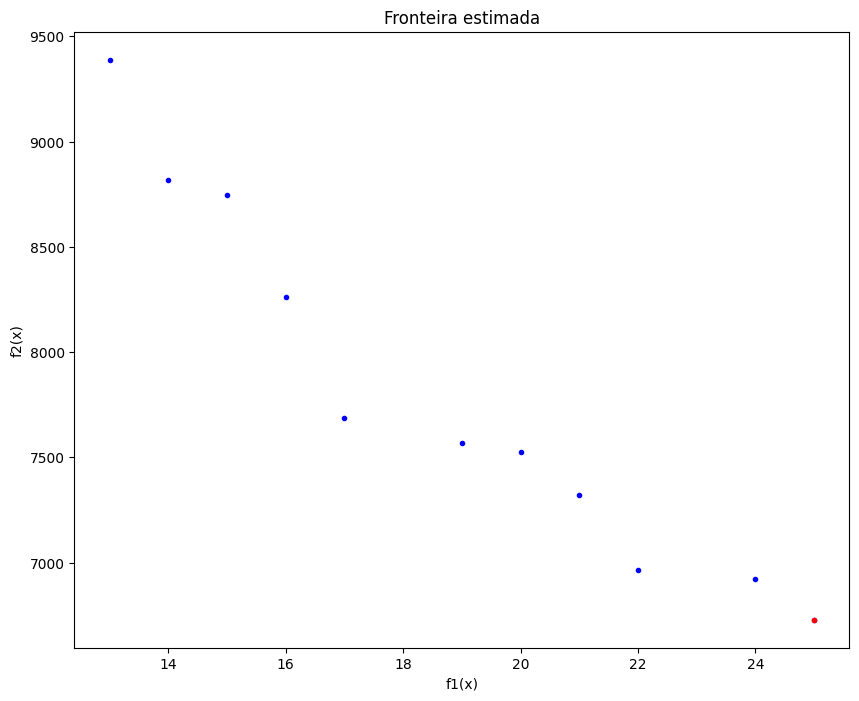

In [146]:
plt.figure(figsize=(10,8))
for i in fronteira_final:
      plt.plot(i.f1,i.f2, "b.")

plt.title('Fronteira estimada')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')

plt.plot(solucao.f1, solucao.f2, "r.")

plt.show()

Solução Final

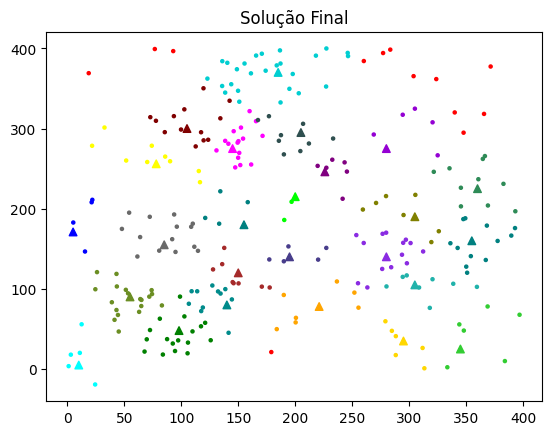

In [147]:

plt.figure()
plt.title('Solução Final');
scatterX = []
scatterY = []
for i in solucao.solution:
    scatterX.append(i[0])
    scatterY.append(i[1])

cores = [cliente.color for cliente in solucao.clientes]
coordX = [cliente.coord[0] for cliente in solucao.clientes]
coordY = [cliente.coord[1] for cliente in solucao.clientes]

plt.scatter(scatterX, scatterY, s=30, c=colors[:len(scatterX)], marker="^")
plt.scatter(coordX, coordY, s=5, c=cores)


plt.show()

Implantação do método PROMETHEE II

In [118]:
def prometheePriority(matrix, weights):
    priorityMatrix = []
    for linha1 in range(matrix.shape[0]):
        for linha2 in range(matrix.shape[0]):
            lineValues = []
            for coluna in range(matrix.shape[1]):
                if(not linha1 == linha2):
                    if(matrix[linha1][coluna] - matrix[linha2][coluna] < 0):
                        lineValues.append(0)
                    else:
                        lineValues.append((matrix[linha1][coluna] - matrix[linha2][coluna])*weights[coluna])
                else:
                    lineValues.append(0)
            if(len(lineValues) > 0):
                priorityMatrix.append(lineValues)
    return np.array(priorityMatrix)



    

In [119]:
def prometheeFlow(matrix):
    positiveFlow = []
    negativeFlow = []

    for linha in range(matrix.shape[0]):
        positiveFlow.append(matrix.sum(axis=1)[linha]/(matrix.shape[0]-1))
    for coluna in range(matrix.shape[1]):
        negativeFlow.append( matrix.sum(axis=0)[coluna]/(matrix.shape[1]-1) )


    return np.array(positiveFlow) - np.array(negativeFlow)

            


In [120]:
def aggredgatedPreferenceFunction(matrix, dimensao):
    aggredatedPreferenceMatrix = []

    lineValues = []
    for linha in range(matrix.shape[0]):
        lineValues.append(matrix[linha].sum())
        if((linha+1)%dimensao == 0 and linha > 0):
            aggredatedPreferenceMatrix.append(lineValues)
            lineValues = []
    return np.array(aggredatedPreferenceMatrix)

In [172]:
def promethee(matrix, weights):
  normalized_matrix = normalizeMatrix(matrix,20.0, [0,1,2,3])
  priority = prometheePriority(normalized_matrix, weights)
  aggredatedPreferenceMatrix = aggredgatedPreferenceFunction(priority, matrix.shape[0])
  resultFlow = prometheeFlow(aggredatedPreferenceMatrix)  

  return resultFlow,normalized_matrix,priority,aggredatedPreferenceMatrix,resultFlow


# Aplica o método PROMETHEE II
result,normalized_matrix,priority,aggredatedPreferenceMatrix,resultFlow = promethee(matriz_decisao,  pesos)
resultIndex = np.argsort(result)[::-1]
print("Melhor alternativa {}".format(resultIndex[0]))


Melhor alternativa 3


Matriz Normalizada

In [166]:
print(normalized_matrix)

[[ 6.66666667 15.54803281 13.39666538 11.83497456]
 [20.         -0.         -0.          1.60879842]
 [18.33333333  4.29437126  3.20960694 -0.        ]
 [-0.         20.         20.         20.        ]
 [16.66666667  4.83169653  4.88785418  0.50862982]
 [15.          8.48411419  5.64375402  4.83416494]
 [ 8.33333333 14.02618457 12.52212115 12.56143403]
 [ 1.66666667 18.55225698 14.47968531 12.92027314]
 [ 5.         18.23722781 14.23967468 18.05121438]
 [13.33333333 12.78820541 11.64641646  7.80939196]
 [10.         13.6869565  15.15949045 13.23372584]]


Matriz de prioridades

In [168]:
print(priority)

[[0.         0.         0.         0.        ]
 [0.         6.21921312 4.01899961 2.04523523]
 [0.         4.50146462 3.05611753 2.36699491]
 [0.66666667 0.         0.         0.        ]
 [0.         4.28653451 2.55264336 2.26526895]
 [0.         2.82556745 2.32587341 1.40016192]
 [0.         0.6087393  0.26236327 0.        ]
 [0.5        0.         0.         0.        ]
 [0.16666667 0.         0.         0.        ]
 [0.         1.10393096 0.52507467 0.80511652]
 [0.         0.74443052 0.         0.        ]
 [1.33333333 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.16666667 0.         0.         0.32175968]
 [2.         0.         0.         0.        ]
 [0.33333333 0.         0.         0.22003372]
 [0.5        0.         0.         0.        ]
 [1.16666667 0.         0.         0.        ]
 [1.83333333 0.         0.         0.        ]
 [1.5        0.         0.         0.        ]
 [0.66666667 0.         0.         0.        ]
 [1.         

Matriz de preferência agregada

In [167]:
print(aggredatedPreferenceMatrix)

[[ 0.         12.28344796  9.92457706  0.66666667  9.10444682  6.55160278
   0.87110257  0.5         0.16666667  2.43412215  0.74443052]
 [ 1.33333333  0.          0.48842635  2.          0.55336705  0.5
   1.16666667  1.83333333  1.5         0.66666667  1.        ]
 [ 1.16666667  2.68063059  0.          1.83333333  0.16666667  0.33333333
   1.          1.66666667  1.33333333  0.5         0.83333333]
 [ 5.39479235 17.67824032 15.31936941  0.         14.49923917 11.94639513
   6.12060302  3.65113699  2.8229636   7.8289145   5.33062509]
 [ 1.          3.39903487  0.82013024  1.66666667  0.          0.16666667
   0.83333333  1.5         1.16666667  0.33333333  0.66666667]
 [ 0.83333333  5.73184518  3.37297428  1.5         2.55284404  0.
   0.66666667  1.33333333  1.          0.16666667  0.5       ]
 [ 0.31195856 11.55763729  9.19876639  0.83333333  8.37863615  5.82579211
   0.          0.66666667  0.33333333  1.70831148  0.13569123]
 [ 1.74365536 14.02710333 11.66823243  0.16666667 10.848

Fluxo final

In [169]:
print (resultFlow)

[ 2.70828971 -9.33683639 -6.92541173  7.90922796 -6.20660179 -3.58180669
  2.0932313   4.07631061  5.353968    0.76408867  3.14554035]


Gráfico com a solução final destacada

In [170]:
solucao = fronteira_final[resultIndex[0]]

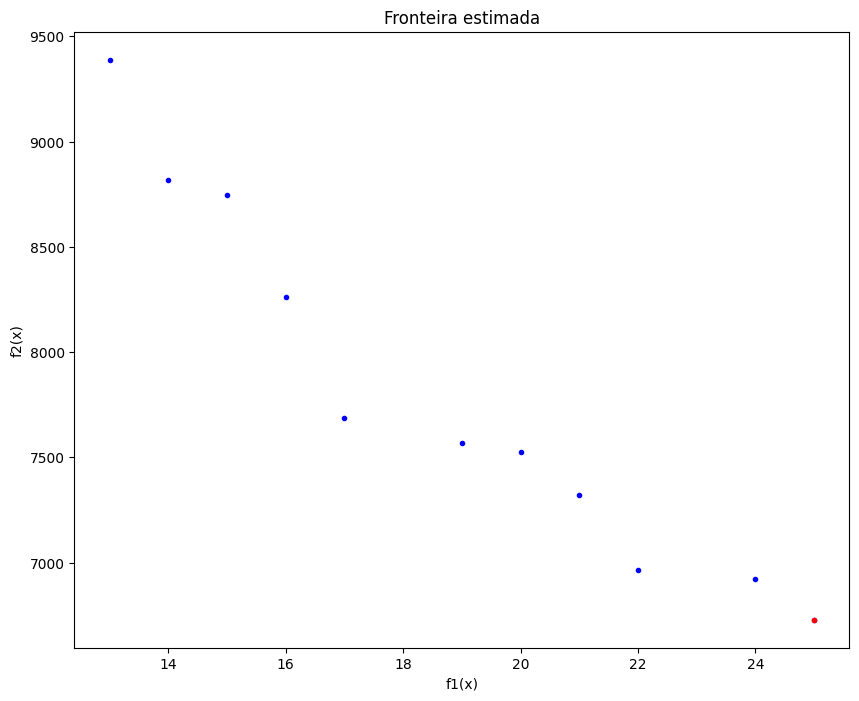

In [173]:
plt.figure(figsize=(10,8))
for i in fronteira_final:
      plt.plot(i.f1,i.f2, "b.")

plt.title('Fronteira estimada')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')

plt.plot(solucao.f1, solucao.f2, "r.")

plt.show()

Solução final

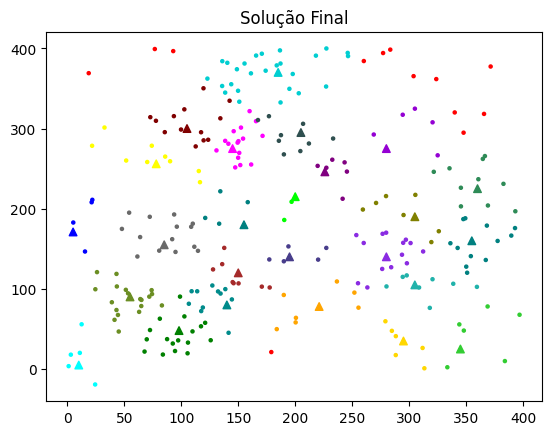

In [175]:

plt.figure()
plt.title('Solução Final');
scatterX = []
scatterY = []
for i in solucao.solution:
    scatterX.append(i[0])
    scatterY.append(i[1])

cores = [cliente.color for cliente in solucao.clientes]
coordX = [cliente.coord[0] for cliente in solucao.clientes]
coordY = [cliente.coord[1] for cliente in solucao.clientes]

plt.scatter(scatterX, scatterY, s=30, c=colors[:len(scatterX)], marker="^")
plt.scatter(coordX, coordY, s=5, c=cores)


plt.show()